In [2]:
!pip install fastf1 matplotlib seaborn pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.2/151.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 6.8 MB/s eta 0:00:00
  Attempting uninstall: websockets
    Found existing installation: websockets 15.0.1
    Uninstalling websockets-15.0.1:
      Successfully uninstalled websockets-15.0.1


In [3]:
import fastf1
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Setup cache
os.makedirs('data/cache', exist_ok=True)
fastf1.Cache.enable_cache('data/cache')

# Load a race session – change 'Q' to 'R' if you want race data
session = fastf1.get_session(2023, 'Monza', 'Q')
session.load()

# Get all laps from all drivers
laps = session.laps
print("All laps shape:", laps.shape)
laps[['Driver', 'Team', 'LapNumber', 'Compound', 'Stint', 'LapTime']].head()


core           INFO 	Loading data for Italian Grand Prix - Qualifying [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Italian Grand Prix - Qualifying [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for sess

All laps shape: (327, 31)


,Driver,Team,LapNumber,Compound,Stint,LapTime
0,SAI,Ferrari,1.0,HARD,1.0,NaT
1,SAI,Ferrari,2.0,HARD,1.0,0 days 00:01:22.321000
2,SAI,Ferrari,3.0,HARD,1.0,0 days 00:02:04.404000
3,SAI,Ferrari,4.0,HARD,2.0,0 days 00:02:22.338000
4,SAI,Ferrari,5.0,HARD,2.0,0 days 00:01:21.965000


In [4]:
# Remove out-laps and in-laps
laps_cleaned = laps[~laps['PitOutTime'].notnull() & ~laps['PitInTime'].notnull()]
laps_cleaned = laps_cleaned[laps_cleaned['LapTime'].notnull()]
laps_cleaned = laps_cleaned[laps_cleaned['LapTime'] > pd.Timedelta(seconds=50)]  # Remove very slow laps

# Convert to seconds
laps_cleaned['LapTimeSeconds'] = laps_cleaned['LapTime'].dt.total_seconds()


<ipython-input-5-8a8a31d1f0e1>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fastest_laps.values, y=fastest_laps.index, palette="mako")


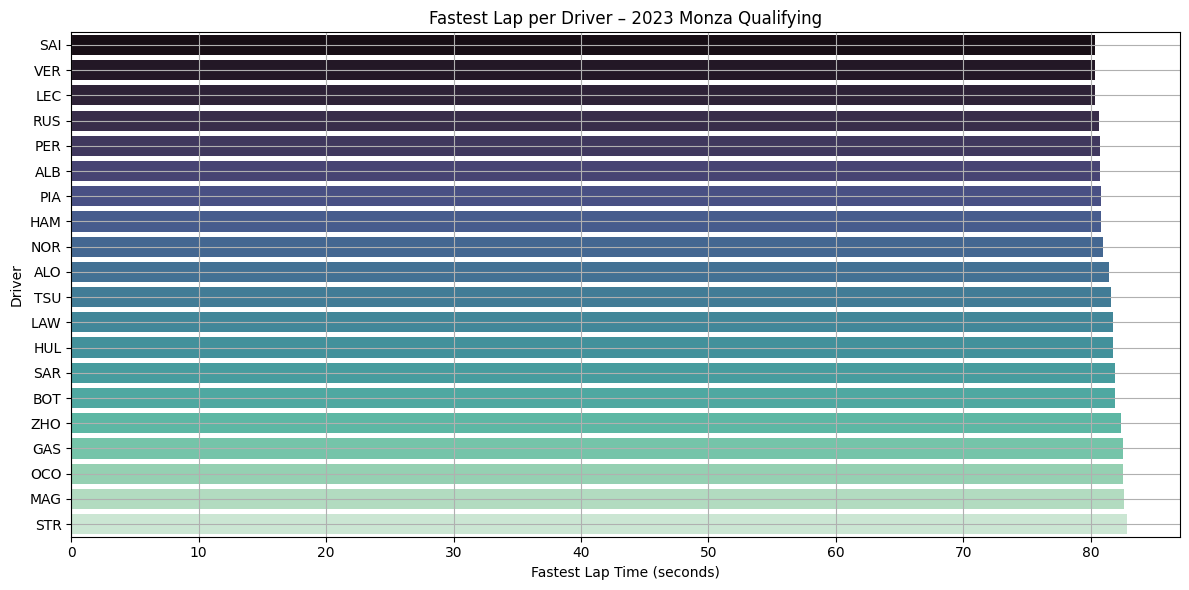

In [5]:
# Group by driver and get their best lap
fastest_laps = laps_cleaned.groupby("Driver")["LapTimeSeconds"].min().sort_values()

plt.figure(figsize=(12, 6))
sns.barplot(x=fastest_laps.values, y=fastest_laps.index, palette="mako")
plt.xlabel("Fastest Lap Time (seconds)")
plt.title("Fastest Lap per Driver – 2023 Monza Qualifying")
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-6-adb4dba59a34>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


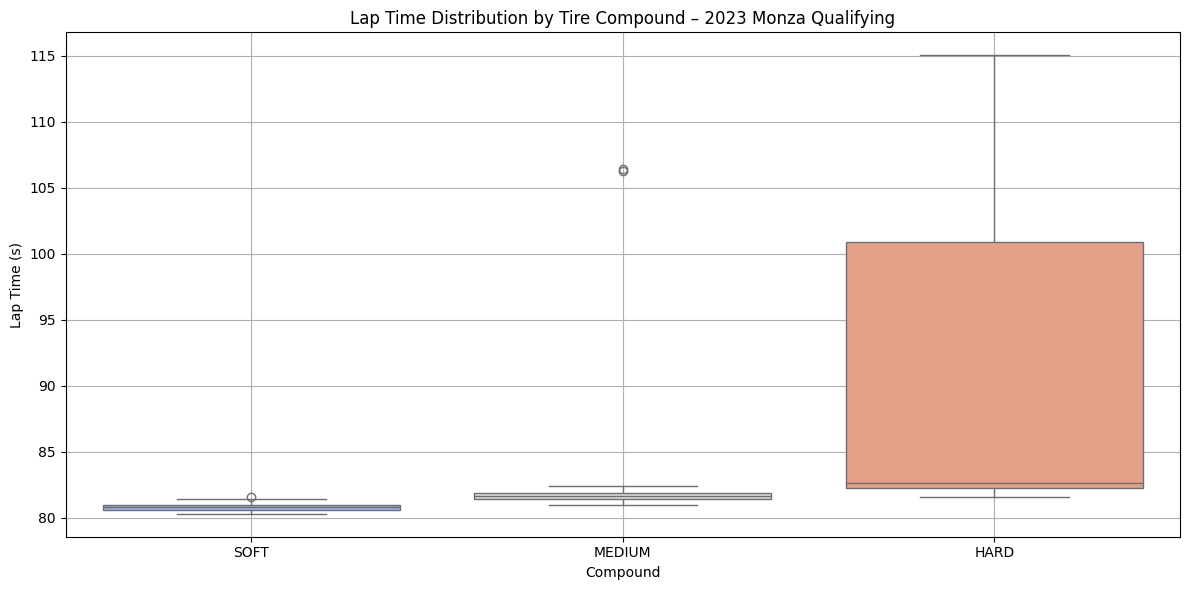

In [6]:
plt.figure(figsize=(12, 6))

sns.boxplot(
    data=laps_cleaned,
    x="Compound",
    y="LapTimeSeconds",
    order=["SOFT", "MEDIUM", "HARD"],  # optional, for order
    palette="coolwarm"
)

plt.title("Lap Time Distribution by Tire Compound – 2023 Monza Qualifying")
plt.ylabel("Lap Time (s)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
avg_compound = laps_cleaned.groupby("Compound")["LapTimeSeconds"].agg(["mean", "std", "count"]).sort_values("mean")
print(avg_compound)


               mean        std  count
Compound                             
SOFT      80.819000   0.347907     20
MEDIUM    83.122812   6.095771     32
HARD      89.185904  10.975651     83


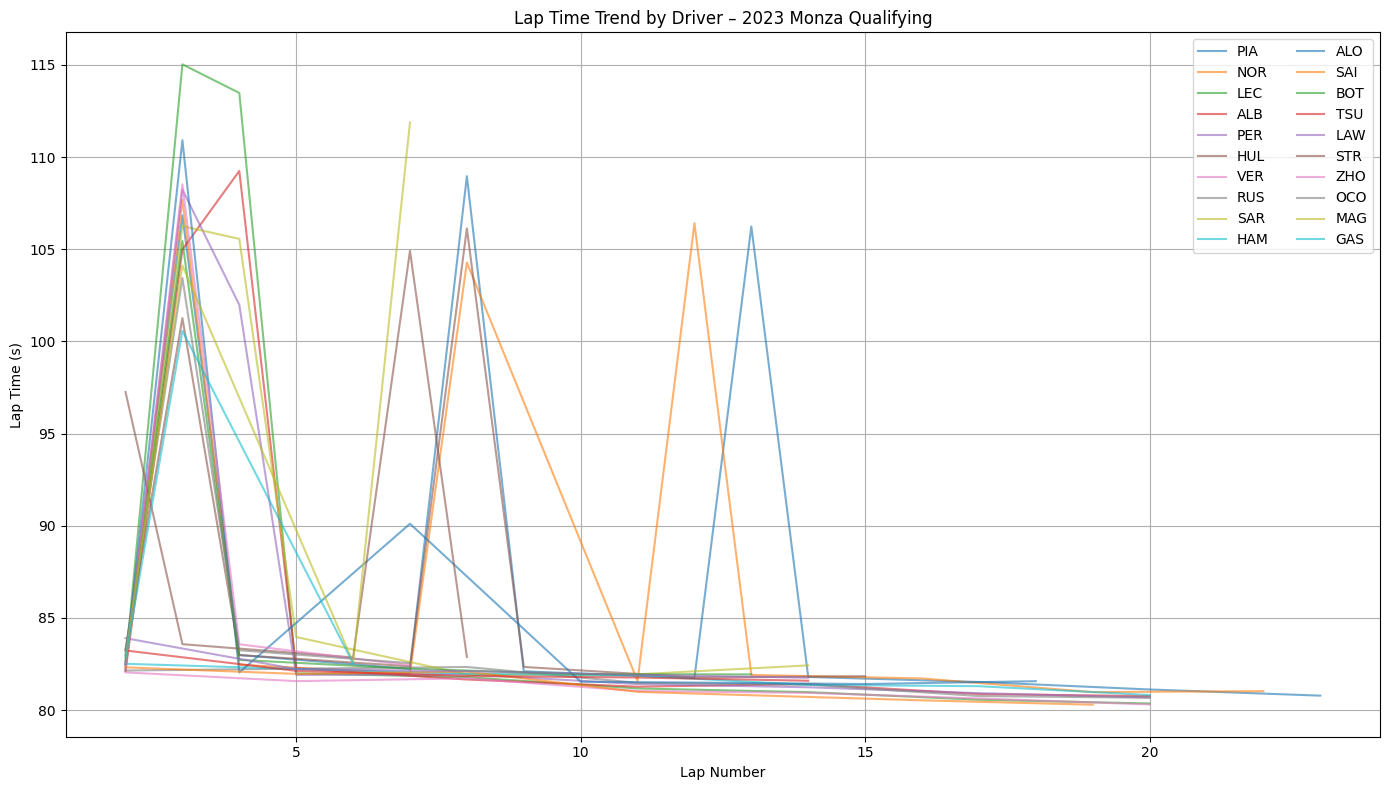

In [8]:
# Filter to drivers with at least 3 valid laps
valid_drivers = laps_cleaned['Driver'].value_counts()
valid_drivers = valid_drivers[valid_drivers >= 3].index.tolist()

plt.figure(figsize=(14, 8))

for driver in valid_drivers:
    driver_laps = laps_cleaned[laps_cleaned['Driver'] == driver]
    plt.plot(driver_laps['LapNumber'], driver_laps['LapTimeSeconds'], label=driver, alpha=0.6)

plt.xlabel("Lap Number")
plt.ylabel("Lap Time (s)")
plt.title("Lap Time Trend by Driver – 2023 Monza Qualifying")
plt.legend(loc='upper right', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()
